<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN 

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoid overfitting that is commonly referred to as the _train/test split_. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Fix a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

Try a variety of response variables. Start with **MEDV** / `.target` attribute from the data set load method.

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [135]:
import matplotlib.pyplot as plt

%matplotlib inline

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics

from sklearn.datasets import load_boston

boston = load_boston()

In [137]:
#according to the description of the boston dataset below, there are no missing attribute values
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1. Clean Up Any Data
Load the Boston housing data. Fix any problems, if applicable.

In [138]:
X = pd.DataFrame(boston.data, columns = boston.feature_names )
y = pd.DataFrame(boston.target, columns=['MEDV'])

In [19]:
#concatenate the X and y before doing EDA
boston = pd.concat([X,y], axis=1)

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always EDA.

In [20]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [21]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [22]:
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [23]:
#check how many unique values there are for each feature
boston.nunique()

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
dtype: int64

In [24]:
 #:Attribute Information (in order):
  #      - CRIM     per capita crime rate by town
   #     - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
    #    - INDUS    proportion of non-retail business acres per town
     #   - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
      #  - NOX      nitric oxides concentration (parts per 10 million)
  #      - RM       average number of rooms per dwelling
   #     - AGE      proportion of owner-occupied units built prior to 1940
    #    - DIS      weighted distances to five Boston employment centres
     #   - RAD      index of accessibility to radial highways
      #  - TAX      full-value property-tax rate per $10,000
 #       - PTRATIO  pupil-teacher ratio by town
  #      - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
   #     - LSTAT    % lower status of the population
    #    - MEDV     Median value of owner-occupied homes in $1000's

In [25]:
from sklearn.linear_model import LinearRegression
# Instantiate an ordinary least squares LinearRegression model and fit linear model
linreg = LinearRegression()
linreg.fit(X, y)
y_pred = linreg.predict(X)


In [26]:
#Testing the model with the same data as it was trained with 
#is not a good estimate for out of sample data
print('MSE:', round(metrics.mean_squared_error(y, y_pred), 3))

MSE: 21.895


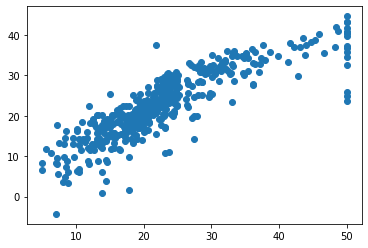

In [27]:
plt.scatter(y, y_pred)

## Using `scikit-learn` Linear Regression

### 2. Select 3–4 variables from your data set on which to perform a 50/50 test-train split.
Score and plot your predictions.

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

feature_columns= ['CRIM', 'RM', 'PTRATIO', 'B']

X_train, X_test, y_train, y_test = train_test_split(X[feature_columns], y, train_size=0.5, random_state=1)
# Instantiate LinearRegression model and fit linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

print('R2: ', round(lr.score(X_test, y_test),3))

R2:  0.631


In [29]:
#predictions using the linear model
y_pred = lr.predict(X_test)

#Mean Square Error:
print('MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

MSE: 32.37


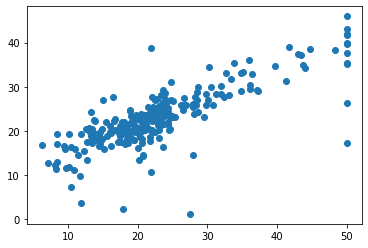

In [30]:
plt.scatter(y_test, y_pred)

### 3. Try 70/30 and 90/10
Score and plot. How do your metrics change?

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[feature_columns], y, train_size=0.7, random_state=1)

# Instantiate LinearRegression model and fit linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

#R Squared calc
print('R2: ', round(lr.score(X_test, y_test),3))

R2:  0.727


In [32]:
#pred using linear model:
y_pred = lr.predict(X_test)

print('MSE: ', round(metrics.mean_squared_error(y_test, y_pred),3))

MSE:  24.995


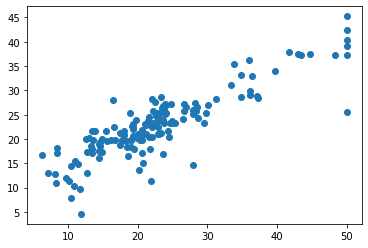

In [33]:
plt.scatter(y_test, y_pred)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X[feature_columns], y, train_size=0.9, random_state=1)

# Instantiate LinearRegression model and fit linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

#R Squared calc
print('R2: ', round(lr.score(X_test, y_test),3))


R2:  0.729


In [35]:
#pred using linear model:
y_pred = lr.predict(X_test)

print('MSE: ', round(metrics.mean_squared_error(y_test, y_pred),3))

MSE:  25.197


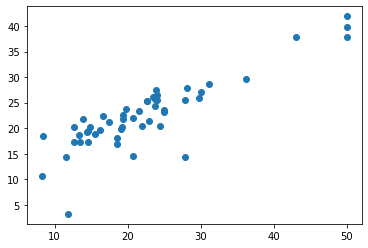

In [36]:
plt.scatter(y_test, y_pred)

In [37]:
#FINDINGS: 
# The 50/50 split, R squared = .631 and MSE = 32.37
# The 70/30 split, R squared = .727 and MSE = 24.995
# The 90/10 split, R squared = .729 and MSE = 25.197

# The 70/30 split appears to be the best split as the MSE is lowest
# and the Rsquared is close to hightest making it the optimum split
#c72 % of the incresae in  Median value of owner-occupied homes in $1000's can be explained by
# the 4 features in the model


### 4. Try K-Fold Between 5-10 for Your Regression
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score.

In [41]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

for fold in range(5,11):
    print('*'*40)
    print(f'k{fold}')
    
    #instanciate the model
    lr = LinearRegression()
    
    cv_score = cross_val_score(lr, X, y,cv=fold)
    print(f'Cross validation score: {cv_score}')
    print(f'Mean of cross validation: {np.mean(cv_score)}')
    print(f'Std deviation: {np.std(cv_score)}')
    
    y_pred = cross_val_predict(lr, X, y, cv=fold)
    
    R2 = metrics.r2_score(y, y_pred)
    print(f'Cross predicted R2:{R2}')



****************************************
k5
Cross validation score: [ 0.63919994  0.71386698  0.58702344  0.07923081 -0.25294154]
Mean of cross validation: 0.3532759243958772
Std deviation: 0.37656783933262267
Cross predicted R2:0.5607291575860869
****************************************
k6
Cross validation score: [ 0.64286835  0.6124552   0.51498797  0.78529513 -0.14696285 -0.00747687]
Mean of cross validation: 0.40019448811385305
Std deviation: 0.3490468795601573
Cross predicted R2:0.5375933284585039
****************************************
k7
Cross validation score: [ 0.6534446   0.59631685  0.67865382  0.61193393  0.51940514 -0.30577687
  0.4001835 ]
Mean of cross validation: 0.4505944247136295
Std deviation: 0.32066859895021876
Cross predicted R2:0.5595353117053623
****************************************
k8
Cross validation score: [ 0.75054889  0.42115868  0.7188866   0.5723991   0.75679427 -0.37293028
 -0.35196626  0.33798142]
Mean of cross validation: 0.35410905269170434
Std de

### Interpretation

In [ ]:
#K8 is optimal as appears to have the largest unbiased prediction (Cross predicted R squared) 
# The smallest standard deviation is K7
# The std deviation is highest with K10 but the mean R2 is the lowest

In [42]:
# I will shuffle the data before rerunning the cross validation above
from sklearn.model_selection import KFold

kf = KFold(10, shuffle=True, random_state=1)

 #instanciate the model
lr = LinearRegression()
    
cv_score = cross_val_score(lr, X, y,cv=kf)
print(f'Cross validation score: {cv_score}')
print(f'Mean of cross validation: {np.mean(cv_score)}')
print(f'Std deviation: {np.std(cv_score)}')
    
y_pred = cross_val_predict(lr, X, y, cv=kf)
    
R2 = metrics.r2_score(y, y_pred)
print(f'Cross predicted R2:{R2}')


Cross validation score: [0.77863866 0.76632537 0.8729179  0.44002779 0.84715141 0.71692423
 0.72093063 0.59299064 0.69816152 0.75603868]
Mean of cross validation: 0.7190106820189477
Std deviation: 0.11892348692223248
Cross predicted R2:0.7187728116186991


# KNN Practice

In [43]:
# Read the iris data into a DataFrame
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [45]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [46]:
# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

In [47]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

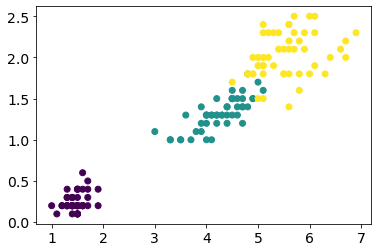

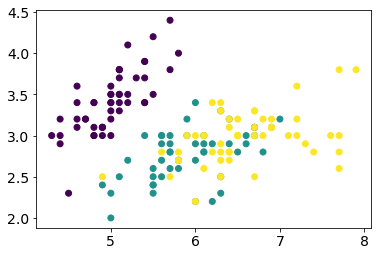

In [48]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = [0 if x == 'Iris-setosa' else 1 if x == 'Iris-versicolor' else 2 for x in iris.species]

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
plt.scatter(iris.petal_length, iris.petal_width, c=iris.species_num)
plt.show() # This just ensures that my plots will show up

# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
plt.scatter(iris.sepal_length, iris.sepal_width, c=iris.species_num);

In [50]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0



## KNN Modeling


### Store Feature Matrix in "X"
This will be all species measurements.

In [101]:
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

### Store Response Vector in "y"
This will be the species type.


In [102]:
y = iris['species_num']

### Make Use of Train-Test-Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=99)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor


In [104]:
from sklearn.neighbors import KNeighborsClassifier

In [105]:
# instantiate a knn instance
knn = KNeighborsClassifier(n_neighbors=1)

# fit the model
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

### Check the Accuracy


In [106]:
y_pred = knn.predict(X_test)

print('Accuracy of model: ', round(metrics.accuracy_score(y_test, y_pred),3))

Accuracy of model:  0.921


### Create a Model With Five Neighbors. Did it Improve?


In [107]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_test, y_test)

KNeighborsClassifier()

In [108]:
y_pred = knn.predict(X_test)

print('Accuracy of model: ', round(metrics.accuracy_score(y_test, y_pred),3))

#There is a c2.5% improvement in the accuracy classification score

Accuracy of model:  0.947


### Create a Looped Function That Will Check All Levels of Various Neighbors and Implement it

In [122]:
knn_range = list(range(1, 101))

train_error = []
test_error = []

for k in knn_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # calculate the training error
    y_pred_train = knn.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
    train_error.append(1-train_accuracy)
    
    # calculate the testing error
    y_pred_test = knn.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test , y_pred_test)
    test_error.append(1-test_accuracy)
    
    
    

In [123]:
columns = {'Training error': train_error, 'Testing error': test_error}

df = pd.DataFrame(columns).sort_index(ascending=False)
df

,Training error,Testing error
99,0.214286,0.236842
98,0.214286,0.236842
97,0.214286,0.236842
96,0.205357,0.236842
95,0.205357,0.236842
...,...,...
4,0.008929,0.078947
3,0.017857,0.052632
2,0.017857,0.078947
1,0.017857,0.078947


Text(0, 0.5, 'error (the lower the error the better)')

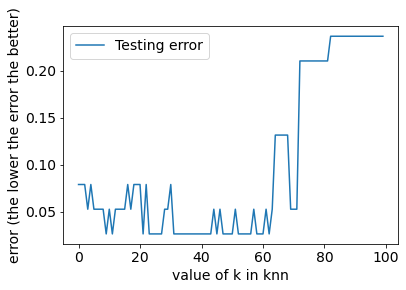

In [127]:
df.plot.line(y='Testing error')
plt.xlabel('value of k in knn')
plt.ylabel('error (the lower the error the better)')

In [131]:
df.sort_values(by='Testing error', ascending=True).head()

,Training error,Testing error
50,0.089286,0.026316
32,0.044643,0.026316
33,0.044643,0.026316
62,0.107143,0.026316
60,0.107143,0.026316


In [ ]:
# The 5 min testing error and corresponding K values

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?


In [133]:
#predict_proba(X_new) returns probability of the test data X being in a particular category 



## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.


In [139]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [140]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf


# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Tue, 29 Mar 2022   Prob (F-statistic):                   1.38e-321
Time:                        15:38:21   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [150]:
from itertools import combinations

X = df.drop('MEDV', 1)
y = boston.target
       


8191

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

In [ ]:
# Check out Pearson scores


### Demo: Patsy

In [ ]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [ ]:
# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

In [ ]:
# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))